In [29]:
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from utils import *
import torch
import torch.utils.data as Data

sns.set_style("white")

In [30]:
parser = argparse.ArgumentParser()

parser.add_argument('--path', type = str, default = 'input\Gold Price.csv')
parser.add_argument('--label', type = str, default = 'USD')

parser.add_argument('--seq_size', type = float, default = 20)

parser.add_argument('--epochs', type = int, default = 1000)
parser.add_argument("--lr", type=float, default = 0.001)

parser.add_argument('--batch_size', type = int, default = 256)

parser.add_argument('--layer_size', type = int, default = 1)
parser.add_argument('--input_size', type = int, default = 8)
parser.add_argument('--hidden_size', type = int, default = 64)
parser.add_argument('--output_size', type = int, default = 1)

args = parser.parse_args(args=[])

In [31]:
df_train = pd.read_csv(args.path)

In [32]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train[args.label] = scaler.fit_transform(df_train[args.label].values.reshape(-1,1))

In [33]:
X, y = tranform_data(*create_seq_data(df_train, args), args.seq_size, args.input_size)

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

In [35]:
model = resLSTM(args.input_size, args.hidden_size, args.layer_size, args.output_size).to(device)

criterion = torch.nn.MSELoss(size_average=True)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

model

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


resLSTM(
  (lstm): LSTM(8, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 1/1000
0 Train Loss: 339.9041
Epoch 2/1000
1 Train Loss: 296.0863
Epoch 3/1000
2 Train Loss: 287.1397
Epoch 4/1000
3 Train Loss: 296.6202
Epoch 5/1000
4 Train Loss: 294.2416
Epoch 6/1000
5 Train Loss: 220.6960
Epoch 7/1000
6 Train Loss: 273.2027
Epoch 8/1000
7 Train Loss: 303.7084
Epoch 9/1000
8 Train Loss: 280.7448
Epoch 10/1000
9 Train Loss: 292.5027
Epoch 11/1000
10 Train Loss: 226.4020
Epoch 12/1000
11 Train Loss: 270.3120
Epoch 13/1000
12 Train Loss: 227.7001
Epoch 14/1000
13 Train Loss: 250.8119
Epoch 15/1000
14 Train Loss: 300.5989
Epoch 16/1000
15 Train Loss: 236.0556
Epoch 17/1000
16 Train Loss: 273.3023
Epoch 18/1000
17 Train Loss: 302.7762
Epoch 19/1000
18 Train Loss: 248.3572
Epoch 20/1000
19 Train Loss: 267.5134
Epoch 21/1000
20 Train Loss: 246.4410
Epoch 22/1000
21 Train Loss: 250.8850
Epoch 23/1000
22 Train Loss: 233.9975
Epoch 24/1000
23 Train Loss: 233.4376
Epoch 25/1000
24 Train Loss: 224.9609
Epoch 26/1000
25 Train Loss: 268.1242
Epoch 27/1000
26 Train Loss: 26

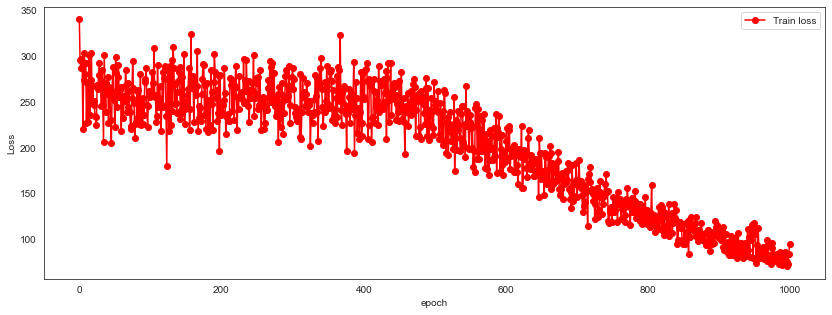

done


In [36]:
train_loss_all = []

for epoch in range(args.epochs):
    print('Epoch {}/{}'.format(epoch + 1, args.epochs))

    model.train()
    train_num = 0
    for (b_x, b_y) in data_loader:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = model(b_x)

        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += 100000 * loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(float(loss) / train_num)
    print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))


plt.figure(figsize=(14, 5))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
print('done')
torch.save(model, 'models/res_LSTM_gold.pkl')

In [37]:
dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)

In [38]:
df_pred = pd.read_csv(args.path).drop(columns='Unnamed: 0')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_pred[args.label] = scaler.fit_transform(df_pred[args.label].values.reshape(-1,1))
X, y = tranform_data(*create_seq_data(df_pred, args), args.seq_size, args.input_size)

In [39]:
model = model.to(torch.device('cpu'))

In [40]:
y_pred_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)

In [41]:
y_pred = scaler.inverse_transform(y_pred_std)
y_label = scaler.inverse_transform(y.reshape(-1,1))

trainScore = mean_squared_error(y_pred, y_label, squared=True)
print('Score: %.2f RMSE' % (trainScore))

Score: 38.16 RMSE


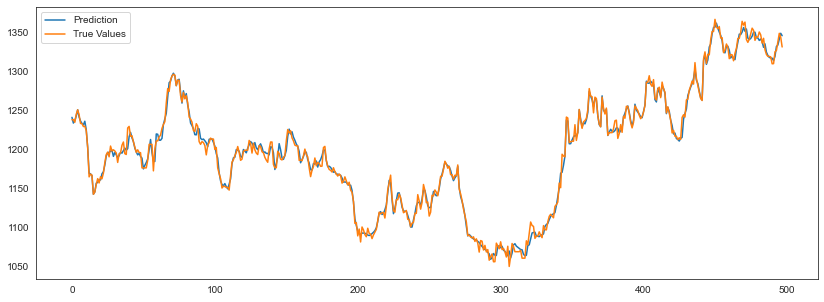

In [42]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(y_label, label = 'True Values')
plt.legend()
plt.show()

In [43]:
result = {'Price': y_label.flatten(), 'Day 1 Prediction': y_pred.flatten()}

In [44]:
X = create_seq_data_for_day_2(df_pred[args.label].values, y_pred_std, args)

g:\2022_MCM - 副本\utils.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [45]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][1:], y_pred, squared=True)

47.80363276984136

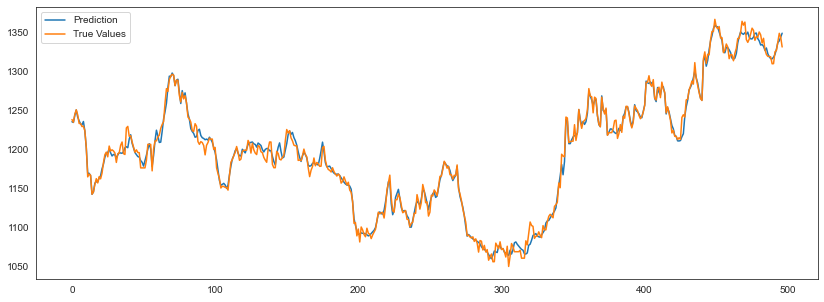

In [46]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][1:], label = 'True Values')
plt.legend()
plt.show()

In [47]:
result['Day 2 Prediction'] = y_pred

In [48]:
X = create_seq_data_for_day_3(df_pred[args.label].values, scaler.transform(result['Day 1 Prediction'].reshape(-1, 1)), scaler.transform(result['Day 2 Prediction'].reshape(-1, 1)), args)

g:\2022_MCM - 副本\utils.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [49]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][2:], y_pred, squared=True)

53.64108370060286

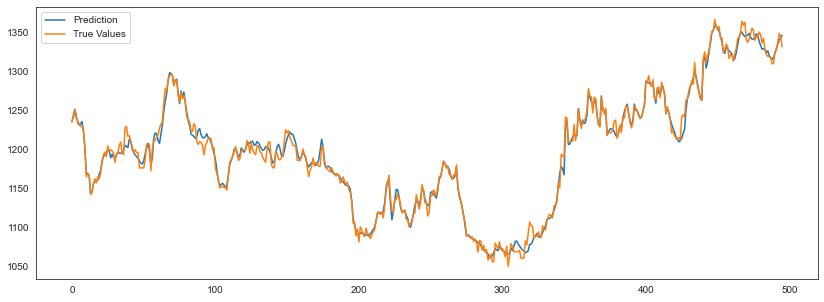

In [50]:
plt.figure(figsize=(14, 5))
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][2:], label = 'True Values')
plt.legend()
plt.show()

In [51]:
result['Day 3 Prediction'] = y_pred.flatten()

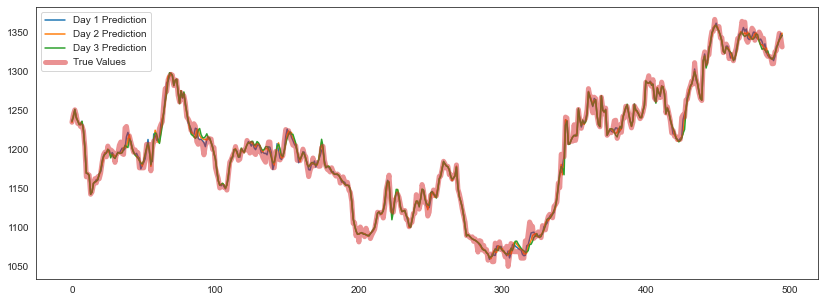

In [52]:
plt.figure(figsize=(14, 5))
plt.plot(result['Day 1 Prediction'][2:], label = 'Day 1 Prediction')
plt.plot(result['Day 2 Prediction'][1:], label = 'Day 2 Prediction')
plt.plot(result['Day 3 Prediction'], label = 'Day 3 Prediction')
plt.plot(result['Price'][2:], label = 'True Values', linewidth = 5, alpha = 0.5)
plt.legend()
plt.show()

In [53]:
df_dic = {}
df_dic['Day 1 Prediction'] = result['Day 1 Prediction'][2:]
df_dic['Day 2 Prediction'] = result['Day 2 Prediction'][1:]
df_dic['Day 3 Prediction'] = result['Day 3 Prediction']
df_dic['Price'] = result['Price'][2:]
df = pd.DataFrame(df_dic)
df.to_csv('results\Price_Prediction\prediction gold price.csv')

In [54]:
df

,Day 1 Prediction,Day 2 Prediction,Day 3 Prediction,Price
0,1236.298706,1234.088989,1235.491943,1234.3
1,1242.488647,1243.223267,1241.004028,1244.5
2,1250.327759,1250.024902,1251.091919,1250.3
3,1240.937378,1240.936279,1239.732666,1243.8
4,1235.937012,1236.318848,1236.333496,1232.8
...,...,...,...,...
491,1331.491699,1327.956055,1329.097290,1326.4
492,1333.354614,1336.546631,1334.682617,1337.3
493,1341.152954,1338.654541,1340.379761,1348.4
494,1348.411377,1343.764893,1342.388550,1343.4


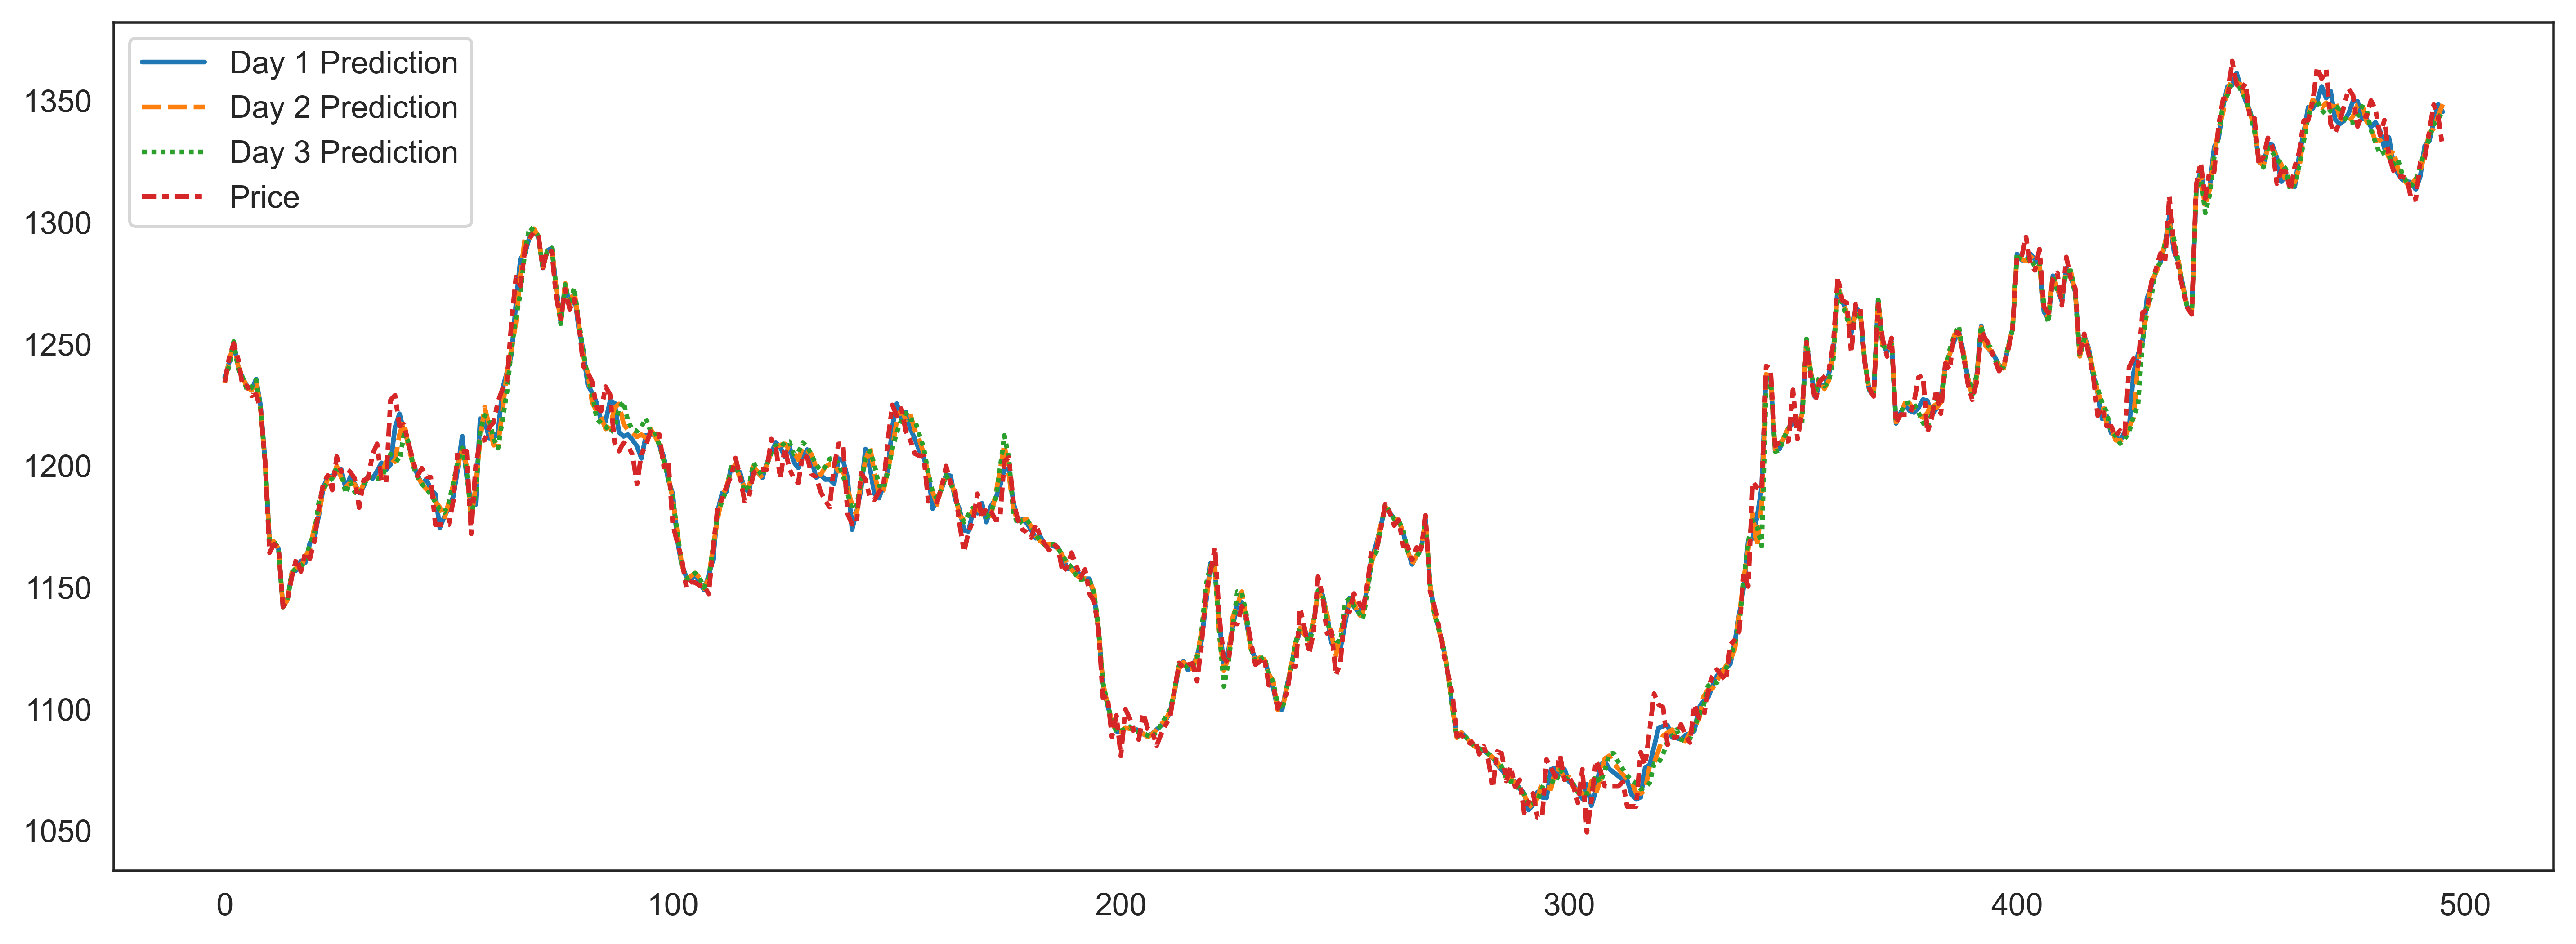

In [55]:
plt.figure(figsize=(14, 5), dpi=500)
sns.lineplot(data=df)
plt.savefig('results\Price_Prediction/gold price prediction.jpg')

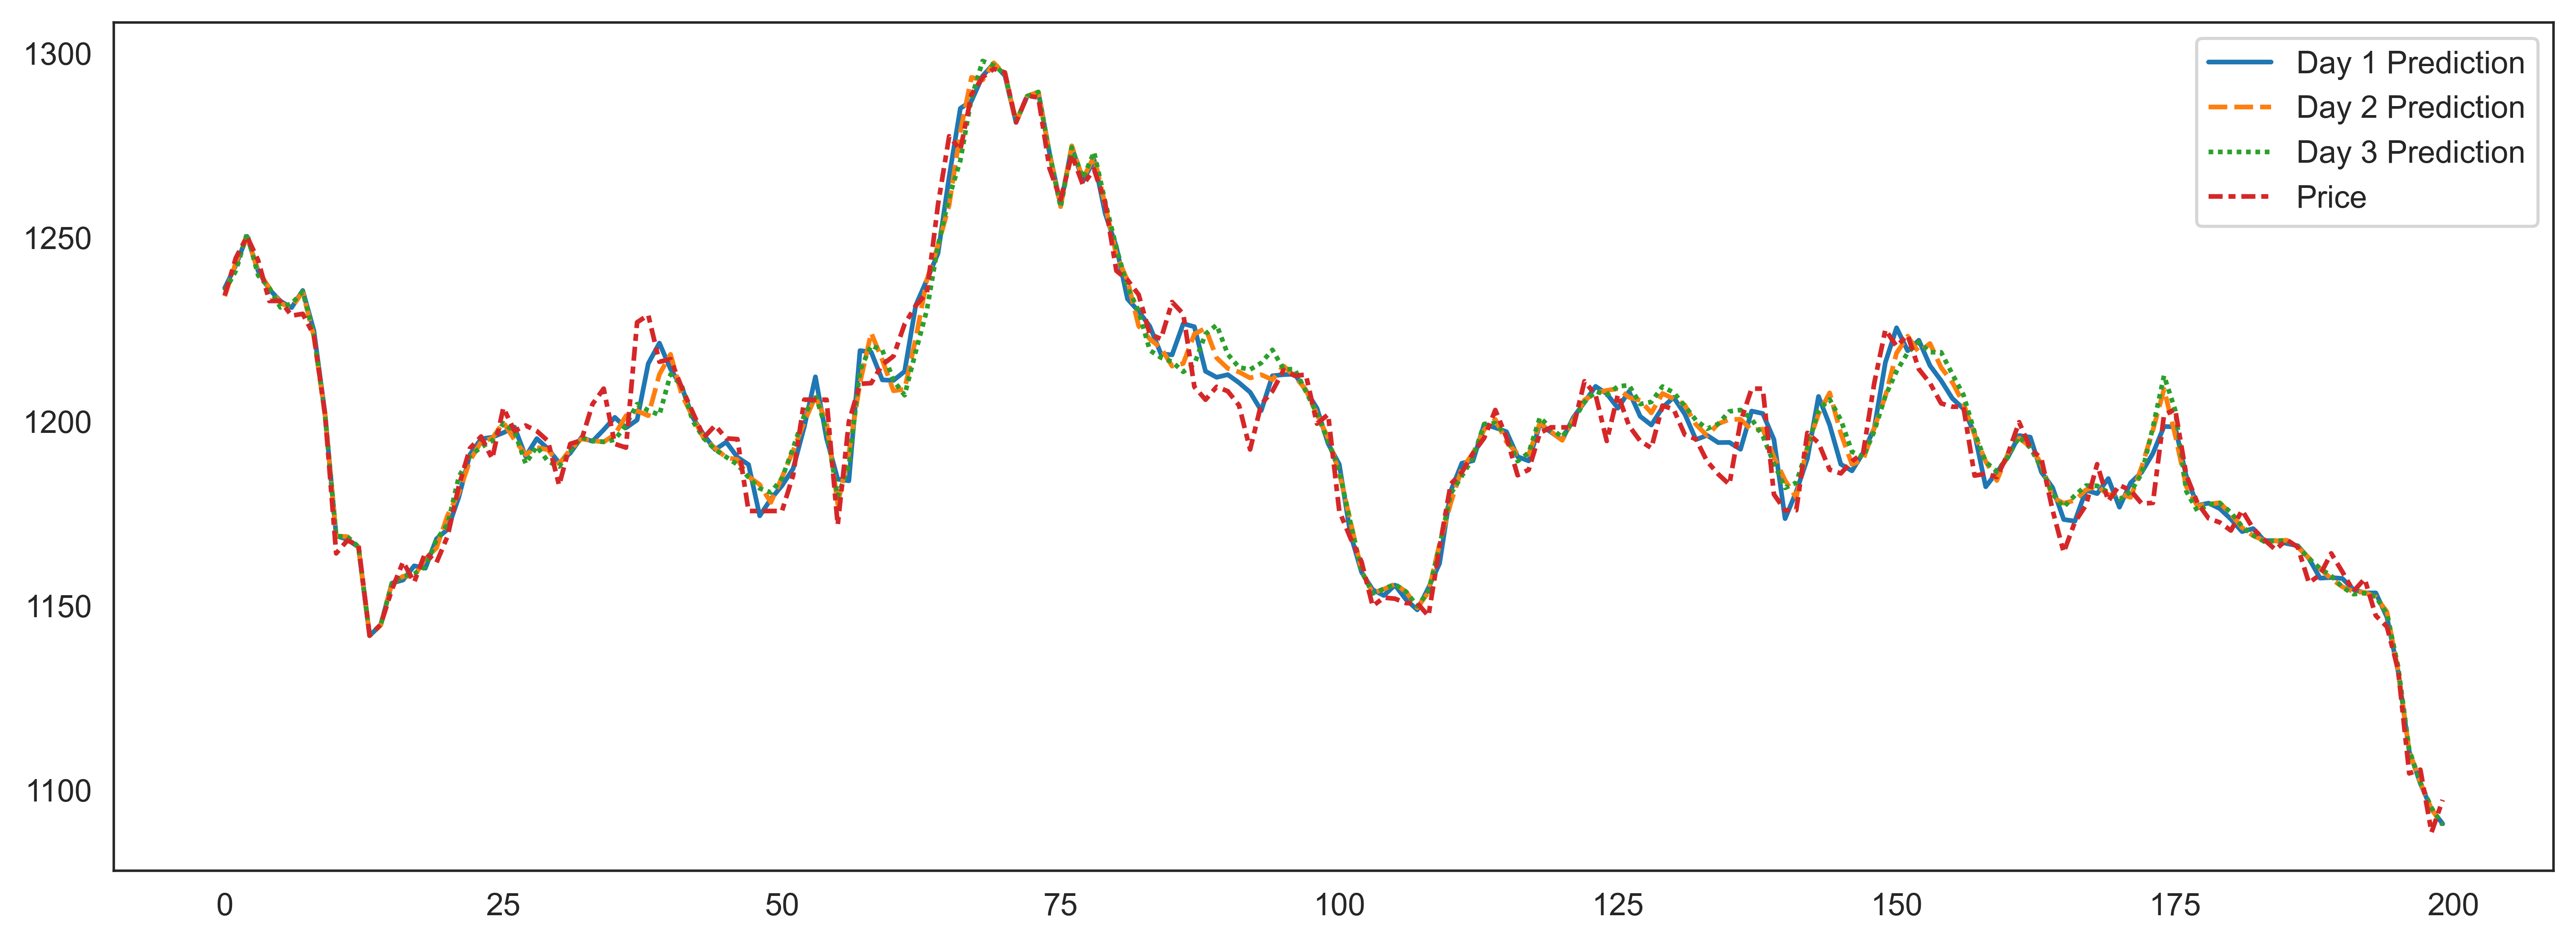

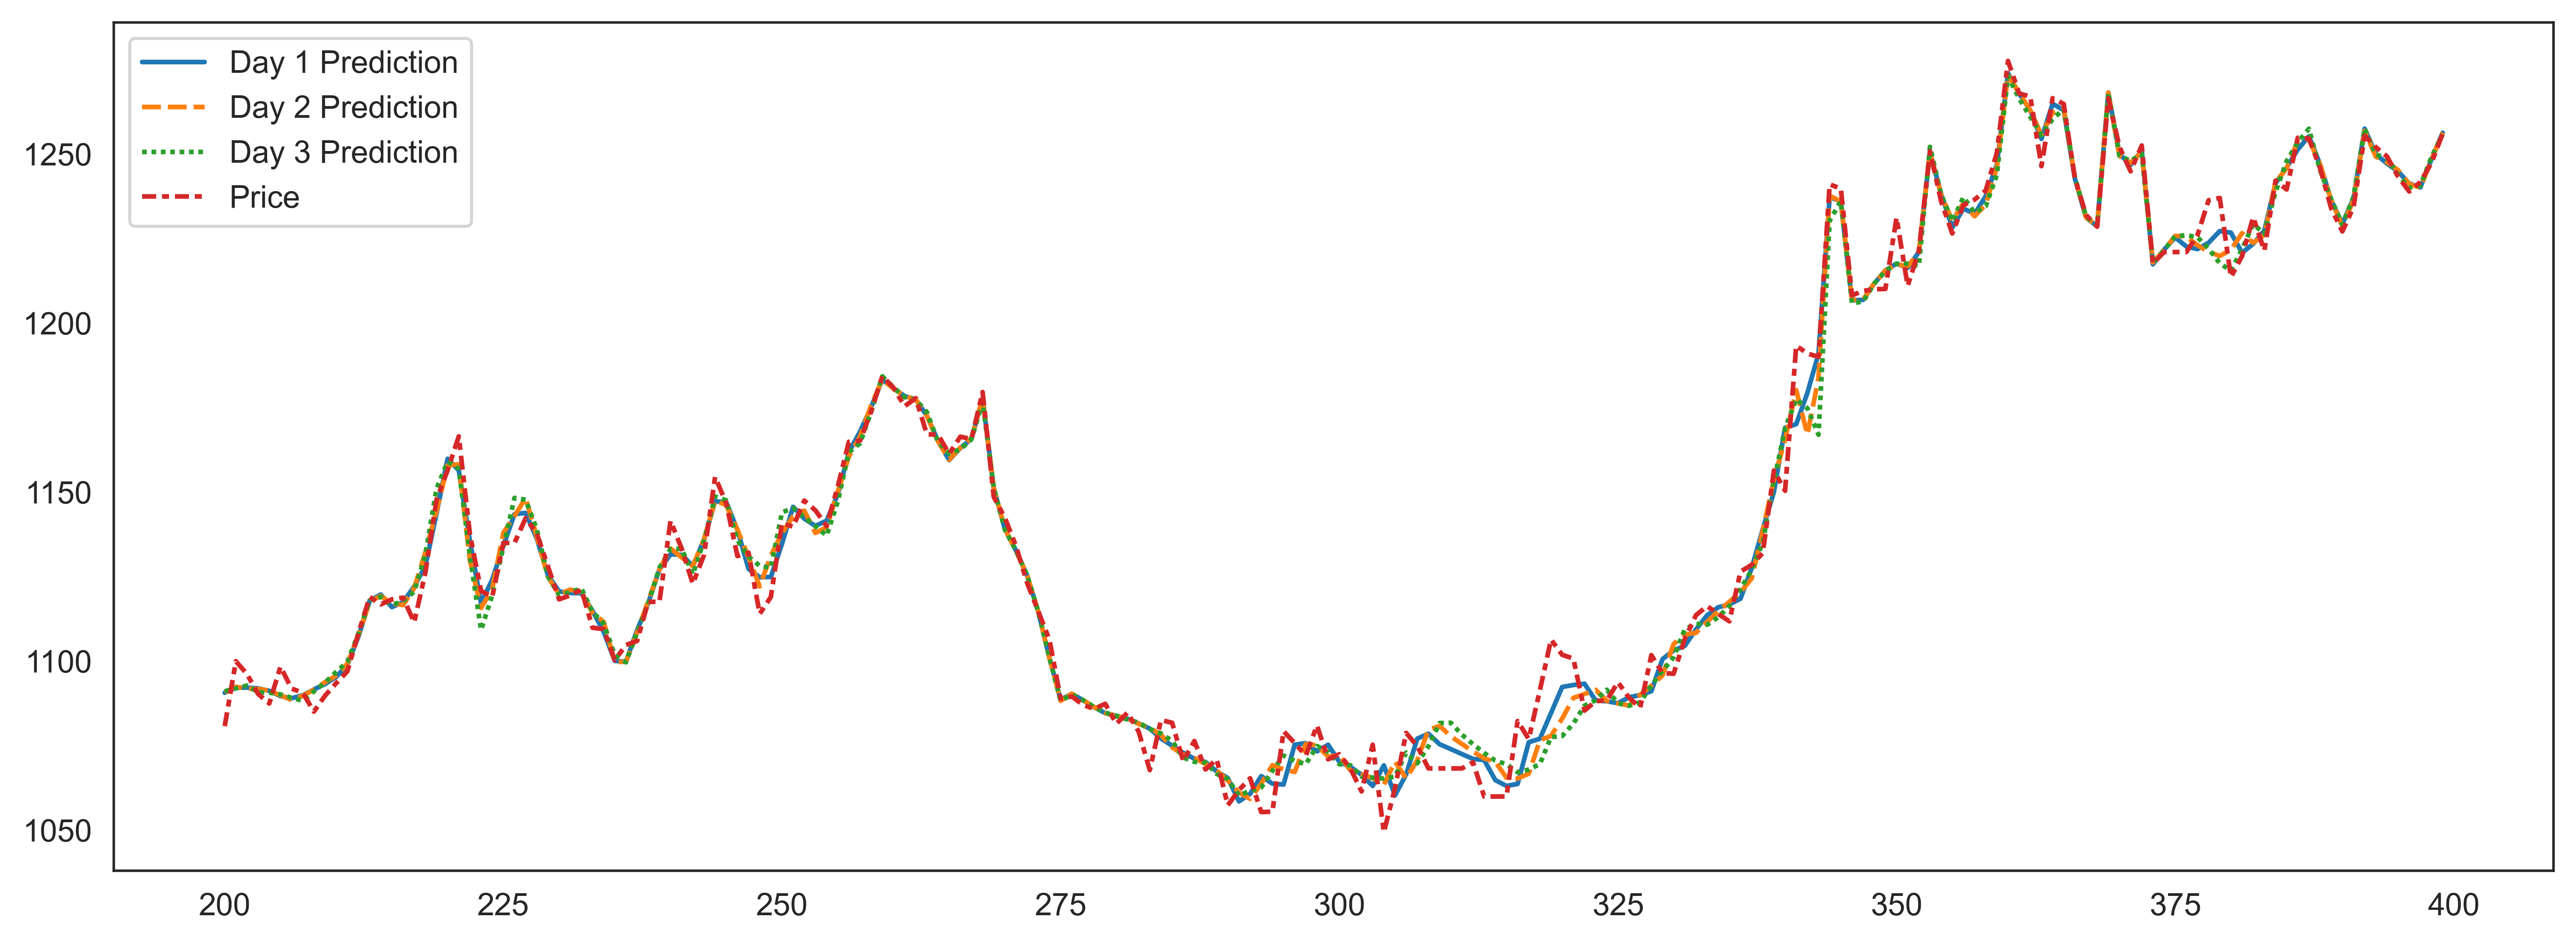

In [56]:
interval = 200
for i in range(len(df_dic['Price']) // interval):
    plt.figure(figsize=(14, 5), dpi=500)
    sns.lineplot(data=df[i * interval: (i + 1) * interval])
    plt.savefig(f'results\Price_Prediction/gold price prediction {i}th.jpg')